<a href="https://colab.research.google.com/github/XingruiWang/Animefy/blob/master/Notebook/Animefy-yourself.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Animefy yourself!

Github 项目在[这里](https://github.com/XingruiWang/Animefy/blob/master/README.md)，里边也有详细介绍与代码。


<img src="https://raw.githubusercontent.com/XingruiWang/Animefy/master/example/example.png" alt="example" style="width: 100%;" />


### 关于项目

这是一个基于StyleGAN2模型的"selfie2anime"项目。你可以使用现实世界的**自拍照片**得到你具有个性的**二次元头像**。


我们大作业的代码是根据StyleGAN2模型\[[官方代码](https://github.com/NVlabs/stylegan2)\]\[[论文](https://arxiv.org/abs/1912.04958)\]\[[视频介绍](https://youtu.be/c-NJtV9Jvp0)\]以及[Justin Pinkney](https://www.justinpinkney.com/)提出的layer swapping 技术 . 同时也参考了[Tetratrio](https://github.com/Tetratrio/stylegan2_pytorch)完成的Pytorch版本的StyleGAN2代码。

### 主要文件介绍

### 数据集

我们使用的数据集为[二次元头像数据集](http://www.seeprettyface.com/mydataset_page3.html#anime)，这个数据集摘选并处理自[DANBOORU2018](https://www.gwern.net/Danbooru2020#danbooru2018)，包含140000张动漫人脸（[百度网盘](https://pan.baidu.com/share/init?surl=8pHjzcOWhVF2u6LKOlT3yg)(提取码：JIMD)）

### 安装项目

1. 复制github项目：

In [2]:
!git clone https://github.com/XingruiWang/Animefy.git

Cloning into 'Animefy'...
remote: Enumerating objects: 256, done.
remote: Counting objects: 100% (256/256), done.
remote: Compressing objects: 100% (196/196), done.
remote: Total 256 (delta 92), reused 181 (delta 53), pack-reused 0
Receiving objects: 100% (256/256), 19.36 MiB | 45.04 MiB/s, done.
Resolving deltas: 100% (92/92), done.


In [9]:
%cd Animefy

/content/Animefy


2. 配置依赖环境（需要在命令行完成）

```bash
conda env create -f environment/anime.yaml
conda activate anime
pip install -r requirements.txt
```

### 训练模型

（注：受限于数据传输，此处notebook使用了样例数据进行训练测试（原数据集2000张随机样本），但可能不能在别的机器上直接运行。如果需要重新运行，请先下载数据。）

- 可以用如下命令进行训练

In [10]:
!python run_training.py settings_with_pretrain.yaml

Traceback (most recent call last):
  File "run_training.py", line 1008, in <module>
    main()
  File "run_training.py", line 1001, in main
    mp.spawn(run_distributed, nprocs=len(args.gpu), args=(args,))
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/spawn.py", line 199, in spawn
    return start_processes(fn, args, nprocs, join, daemon, start_method='spawn')
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/spawn.py", line 157, in start_processes
    while not context.join():
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/spawn.py", line 118, in join
    raise Exception(msg)
Exception: 

-- Process 3 terminated with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/spawn.py", line 19, in _wrap
    fn(i, *args)
  File "/content/Animefy/run_training.py", line 989, in run_distributed
    run(args)
  File "/content/Animefy/run_training.py", line 971, 

或者写成脚本`run.sh`

```bash
sh run.sh
```

* 此处`settings_with_pretrain.yaml`存储了训练中的配置参数。需要设置数据路径`data_dir`，以及与训练模型`g_file`和`d_file`

```yaml
# Here is an example training config file for 512x512 images.
channels: [32, 64, 128, 256, 512, 512, 512, 512]
tensorboard_log_dir: 'runs/stylegan2_512x512_with_pretrain_new_2'
tensorboard_image_interval: 20
checkpoint_dir: 'checkpoints/stylegan2_512x512_with_pretrain_new_2'
checkpoint_interval: 500
data_dir: /DATA2/wxr/anime_face
output_dir: train_output
gpu: [0, 1, 2, 3]
g_file: /home/wxr/stylegan2_pytorch_backup/checkpoints/stylegan2_512x512_with_pretrain_new_2/10000_2020-12-22_03-42-54/G.pth
d_file: /home/wxr/stylegan2_pytorch_backup/checkpoints/stylegan2_512x512_with_pretrain_new_2/10000_2020-12-22_03-42-54/D.pth
iterations: 10000

```

  * 初次训练时，应设置`G_file`为`ffhq`人脸数据集的pretrained模型，另外可以删掉`D_file`

- 我们实际训练过程使用了4张GPU (Titan V)，总共进行了20000次循环（并不是epoch，总共大约2天）。大约2000次循环后，二次元头像已经具有了较高质量（大约4小时）。

- 下载已经训练好的模型

### Layer Swapping

直接训练好的模型并不能用来进行高质量的“selfie2anime”，我们还需要采用layer swapping 技术进行模型调整。StyleGAN2的生成器具有不同的分辨率层，低分辨率层控制着人脸的头部姿势、方向等，高分辨率层控制着面部细节比如五官、肤色等。所以我们将生成真实人脸的生成器的**低分辨率层**（来自FFHQ数据集上的pretrain模型）和我们刚刚训练好的二次元生成模型的**高分辨率层**。这样可以生成具有人脸姿态和二次元风格的自定义头像

In [ ]:
from blend import blend_models

G_out = blend_models("checkpoints/stylegan2_512x512_with_pretrain/pretrain/Gs.pth", 
                     "checkpoints/stylegan2_512x512_with_pretrain_new_2/18500_2020-12-22_23-05-35/Gs.pth", 
                     8, None)
G_out.save('G_out.pth')

### 生成你的头像！

In [11]:
%mkdir raw
%mkdir latent
%mkdir generated

1. 把你自己的照片放到`raw`文件夹里

  这里使用了样例照片

In [14]:
!wget https://upload.wikimedia.org/wikipedia/commons/6/6d/Shinz%C5%8D_Abe_Official.jpg -O raw/example.jpg

--2021-01-16 13:30:41--  https://upload.wikimedia.org/wikipedia/commons/6/6d/Shinz%C5%8D_Abe_Official.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332712 (325K) [image/jpeg]
Saving to: ‘raw/example.jpg’

raw/example.jpg     100%[===================>] 324.91K  --.-KB/s    in 0.09s   

2021-01-16 13:30:41 (3.55 MB/s) - ‘raw/example.jpg’ saved [332712/332712]



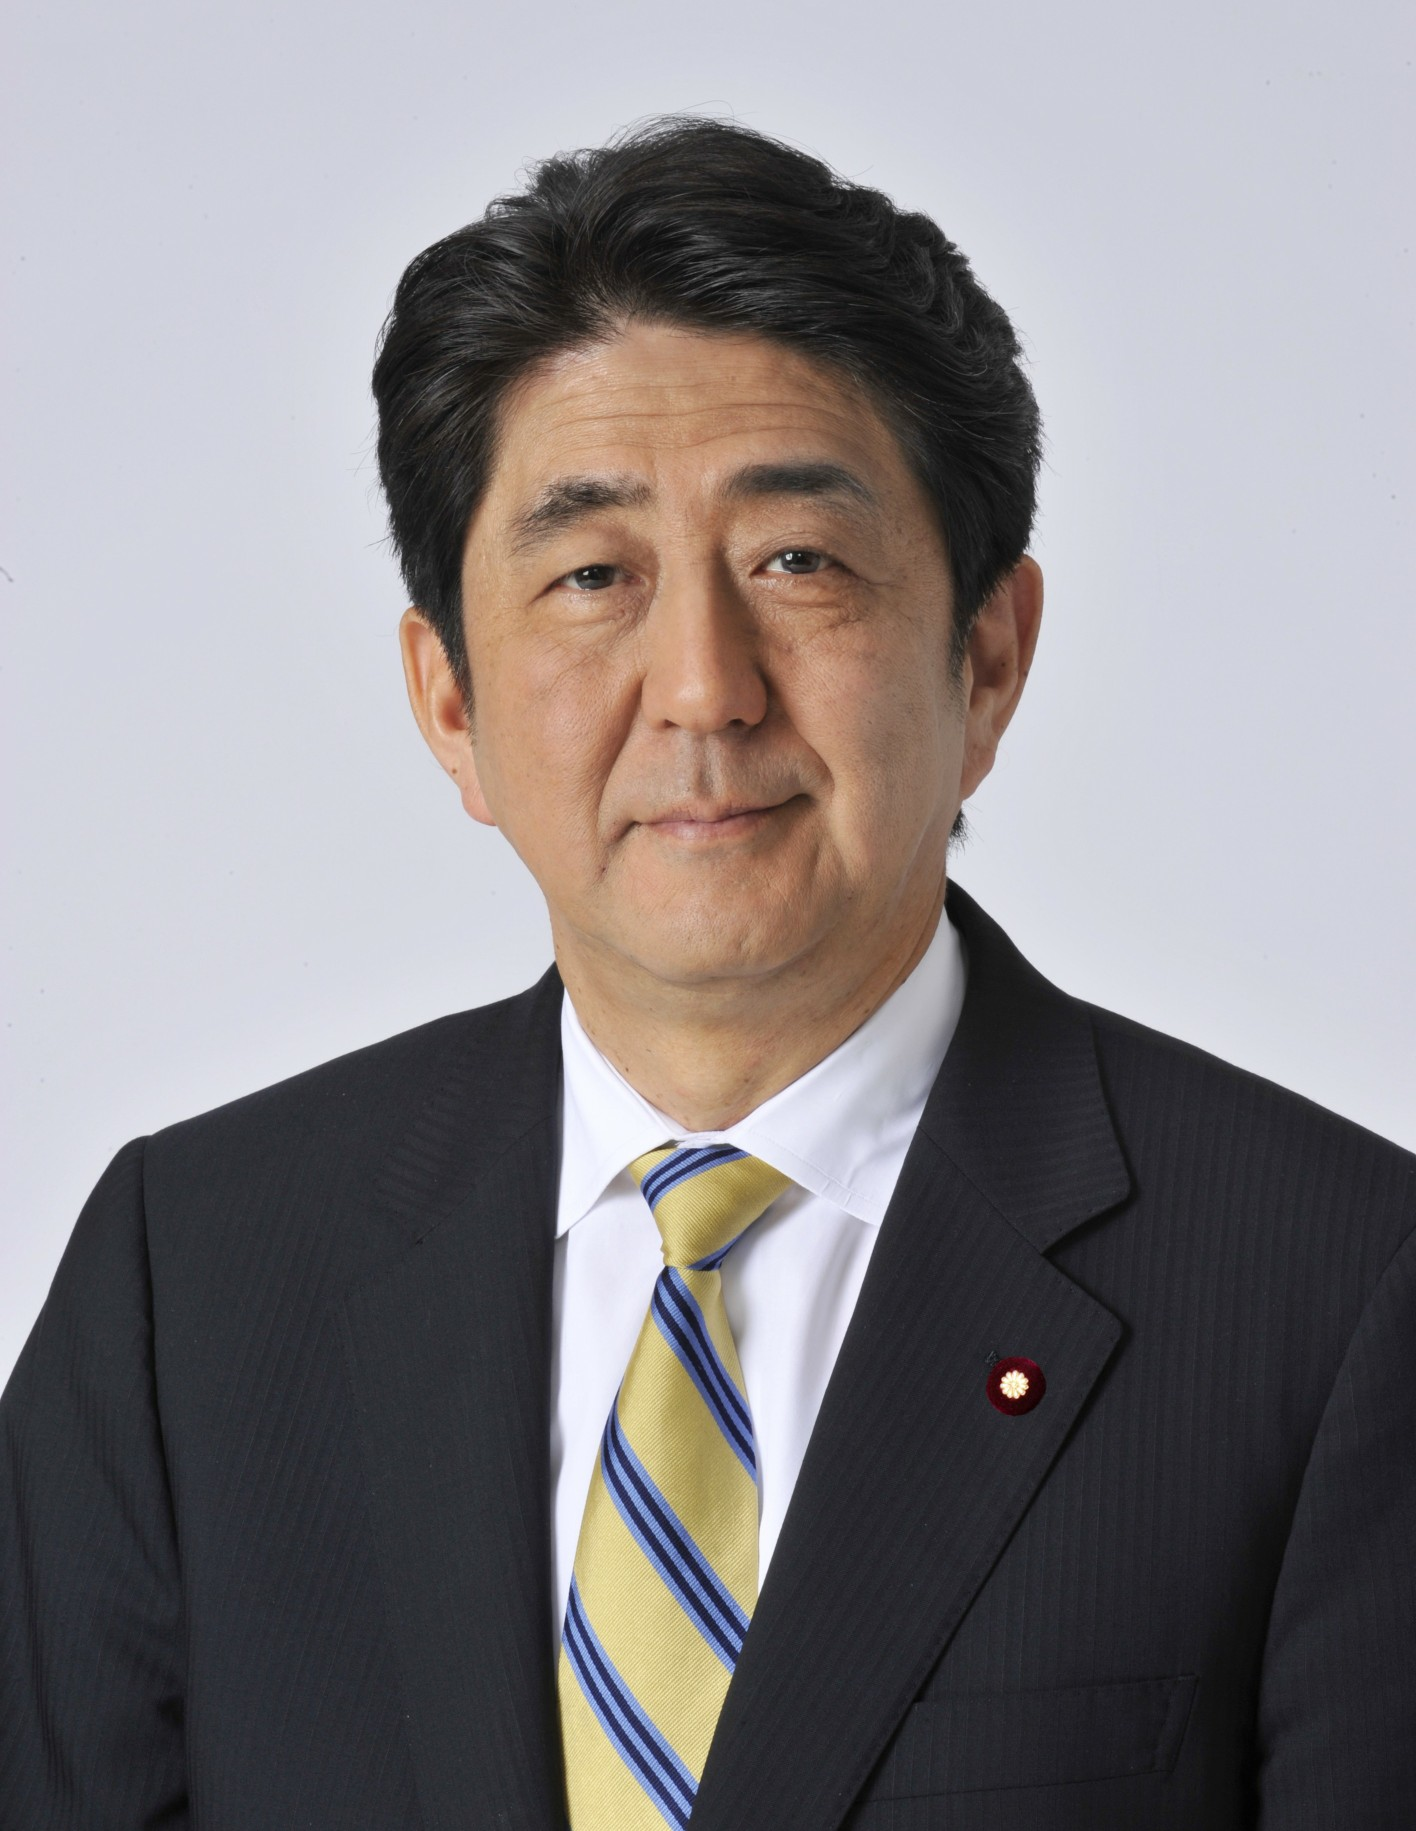

In [15]:
from IPython.display import Image
Image(filename='raw/example.jpg') 

2. 提取人脸

In [20]:
!python align_images.py raw aligned
Image(filename='raw/example.jpg') 

2021-01-16 13:37:21.489712: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Traceback (most recent call last):
  File "align_images.py", line 7, in <module>
    from ffhq_dataset.face_alignment import image_align
ModuleNotFoundError: No module named 'ffhq_dataset'


In [17]:
import cv2 as cv
import os


dir = 'raw'

file = os.listdir(dir)

for f in file:
    print(os.path.join(dir, f))
    if f[-3:] != 'png':
      continue
    img = cv.imread(os.path.join(dir, f))
    img = cv.resize(img, (512, 512), interpolation = cv.INTER_CUBIC)
    cv.imwrite(os.path.join(dir, f), img)

raw/example.jpg


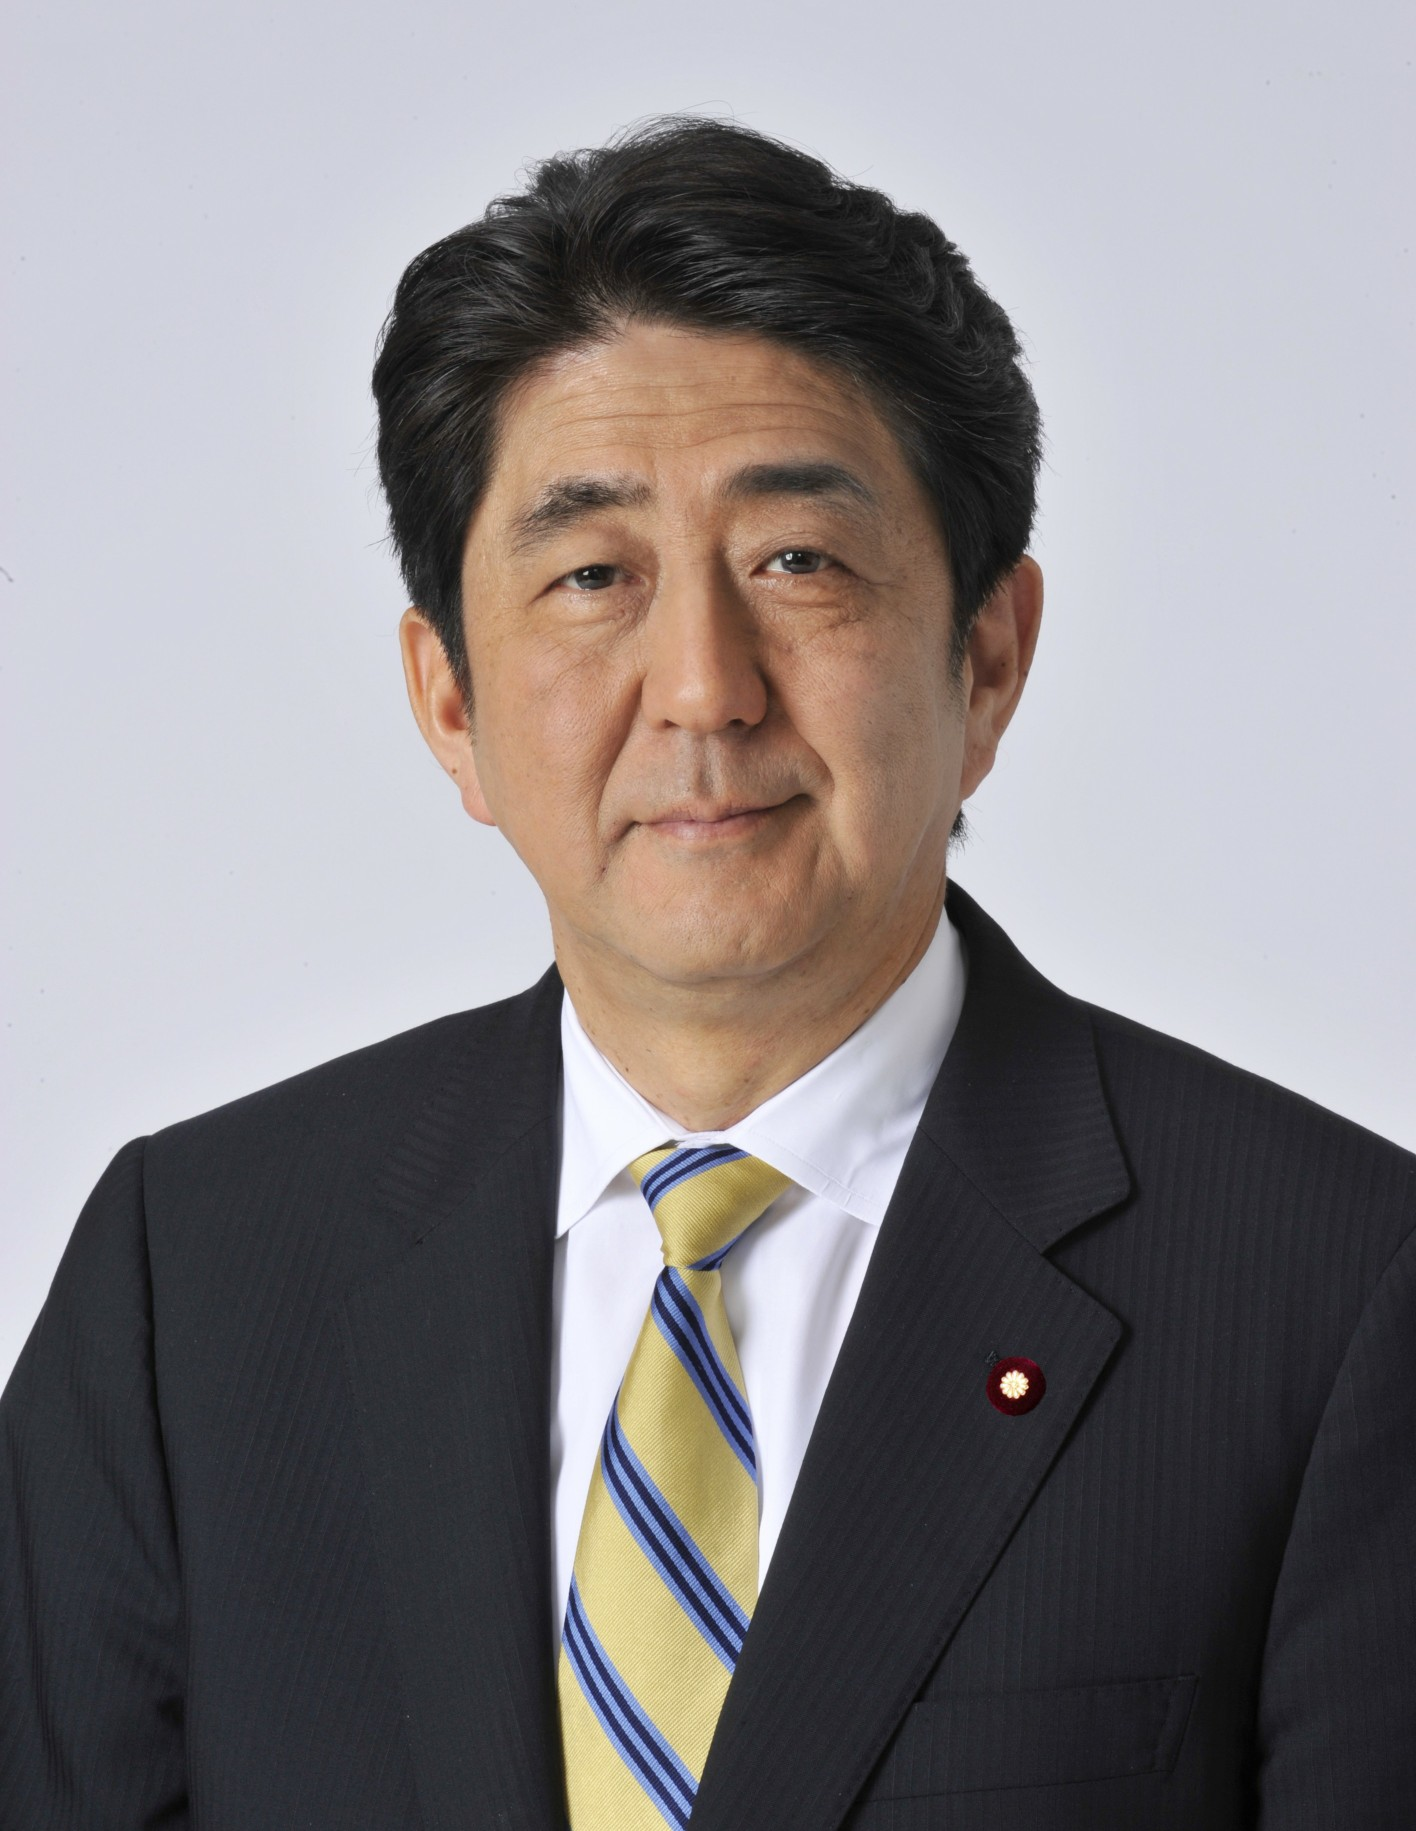

In [18]:
from IPython.display import Image
Image(filename='raw/example.jpg') 

In [19]:
!gdown --id 1BgMHyJwF7KvouTkJ-8MbHy6jDWURQqMo
!gdown --id 19vr5taIJSbNMiqihW1-vWSZkXUK7tdPR

Downloading...
From: https://drive.google.com/uc?id=1BgMHyJwF7KvouTkJ-8MbHy6jDWURQqMo
To: /content/Animefy/G_blend.pth
121MB [00:01, 109MB/s]  
Downloading...
From: https://drive.google.com/uc?id=19vr5taIJSbNMiqihW1-vWSZkXUK7tdPR
To: /content/Animefy/G_pretrain.pth
121MB [00:01, 108MB/s] 


In [ ]:
!python run_projector.py project_real_images --network=G_pretrain.pth --data_dir=/content/GenerateYourOwnAnimateCharacter/raw --output=latent/ --num_steps=100 --gpu=0


Loading images from "/content/GenerateYourOwnAnimateCharacter/raw"...
Traceback (most recent call last):
  File "run_projector.py", line 439, in <module>
    main()
  File "run_projector.py", line 433, in main
    project_real_images(G, args)
  File "run_projector.py", line 396, in project_real_images
    args.data_dir, pixel_min=args.pixel_min, pixel_max=args.pixel_max)
  File "/content/GenerateYourOwnAnimateCharacter/stylegan2/utils.py", line 268, in __init__
    **kwargs
  File "/usr/local/lib/python3.6/dist-packages/torchvision/datasets/folder.py", line 229, in __init__
    is_valid_file=is_valid_file)
  File "/usr/local/lib/python3.6/dist-packages/torchvision/datasets/folder.py", line 114, in __init__
    raise RuntimeError(msg)
RuntimeError: Found 0 files in subfolders of: /content/GenerateYourOwnAnimateCharacter/raw
Supported extensions are: .jpg,.jpeg,.png,.ppm,.bmp,.pgm,.tif,.tiff,.webp


In [ ]:
import os
import numpy as np
import torch
import stylegan2
from stylegan2 import utils
import cv2 as cv
from google.colab.patches import cv2_imshow
from tqdm import tqdm
dir = 'latent'

G_blend = 'G_blend.pth'

def synthesis(G_file, latent_file):
    device = torch.device(0)
    G = stylegan2.models.load(G_file).G_synthesis 
    latent = np.load(latent_file, allow_pickle=True)
    G.to(device)
    latent = torch.tensor(latent[np.newaxis, ...]).to(device)

    out = G(latent)

    out = utils.tensor_to_PIL(out, pixel_min=-1, pixel_max=1)[0]
    return out

for l in tqdm(os.listdir(dir)):
  if l[-3:] == 'png':
    continue
  latent = os.path.join(dir, l)
  out = synthesis(G_blend, latent)
  print(type(out))
  display(out)





  0%|          | 0/6 [00:00<?, ?it/s]


KeyboardInterrupt: ignored